In [2]:
import os
import json
import random

import cv2
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (recall_score, accuracy_score,
                             precision_recall_fscore_support,
                             classification_report,confusion_matrix, f1_score)

import datasets
import preprocessing

import torch
from torch.utils.data import DataLoader
from torchvision import models

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

CLASSES = ['c_kefir', 'staphylococcus_epidermidis', 'ent_cloacae', 'staphylococcus_aureus',
           'klebsiella_pneumoniae', 'moraxella_catarrhalis']

# Dataloader and utility functions 

In [5]:
def visualize_image(image, class_name=None):
    plt.figure(figsize=(16, 5))
    plt.xticks([]); plt.yticks([])
    plt.imshow(image)
    if class_name:
        plt.title(class_name)
    plt.show()

    
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    return image

In [6]:
data = preprocessing.create_labels_from_json()
data.head()

picture    class
0  001.png  c_kefir
1  002.png  c_kefir
2  003.png  c_kefir
3  004.png  c_kefir
4  005.png  c_kefir

In [7]:
data['class'] = data['class'].apply(lambda x: CLASSES.index(x))

# **Prepare data and split to train/val**

In [8]:
data = data.sample(frac=1)
split = int(0.7 * len(data))
train_frame = data[:split]
val_frame = data[split:]
train_frame.index = np.arange(len(train_frame))
val_frame.index = np.arange(len(val_frame))
print("train_frame.shape:", len(train_frame))
print("val_frame.shape:", len(val_frame))

train_frame.shape: 182
val_frame.shape: 79


In [9]:
train_frame['class'].value_counts(normalize=True)

2    0.357143
0    0.252747
5    0.142857
1    0.104396
3    0.087912
4    0.054945
Name: class, dtype: float64

In [10]:
val_frame['class'].value_counts(normalize=True)

2    0.354430
0    0.303797
5    0.164557
1    0.075949
4    0.050633
3    0.050633
Name: class, dtype: float64

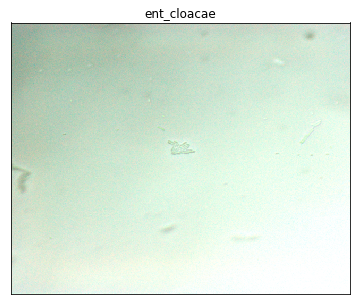

In [12]:
dataset = datasets.ClassificationTrainDataset(data, TRAIN_DIR)
image, label = dataset[random.randint(0, len(data)-1)]

visualize_image(image, CLASSES[label])

## Augmentations

In [27]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [13]:
import albumentations as A

In [14]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)
    
def get_training_augmentation():
    train_transform = [
        A.Resize(224, 224),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0.1, shift_limit=0.1, p=1, border_mode=0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        A.Resize(224, 224)
    ]
    return A.Compose(test_transform)

def get_preprocessing():    
    _transform = [
        A.Normalize()
    ]
    return A.Compose(_transform)

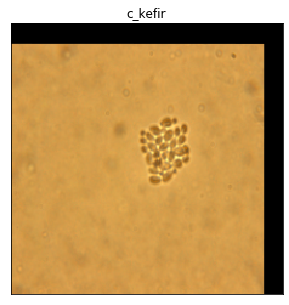

In [18]:
dataset = datasets.ClassificationTrainDataset(data, TRAIN_DIR, augmentation=get_training_augmentation())
image, label = dataset[random.randint(0, len(data)-1)]

visualize_image(image, CLASSES[label])

#**Model training** 

In [ ]:
BATCH_SIZE = 7
NUM_EPOCH = 30

In [ ]:
train_dataset = datasets.ClassificationTrainDataset(
    train_frame,
    TRAIN_DIR,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(),
    reshape=True
)

valid_dataset = datasets.ClassificationTrainDataset(
    val_frame, 
    TRAIN_DIR,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(),
    reshape=True
)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
train_loss_history = []
train_accuracy_history = []

val_loss_history = []
val_accuracy_history = []

def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print(f"Starting epoch: {epoch+1}/{num_epochs} | phase: {phase}", end=' ')
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = valid_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs.float())
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()


            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)

            print(f"Loss: {'%.4f' % epoch_loss} | Acc: {'%.4f' % epoch_acc}")
        print()        

    return model

In [ ]:
model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 6)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=NUM_EPOCH);

Starting epoch: 1/30 | phase: train Loss: 1.5469 | Acc: 0.4065999984741211
Starting epoch: 1/30 | phase: val Loss: 1.0078 | Acc: 0.7857000231742859

Starting epoch: 2/30 | phase: train Loss: 1.1073 | Acc: 0.6428999900817871
Starting epoch: 2/30 | phase: val Loss: 0.665 | Acc: 0.833299994468689

Starting epoch: 3/30 | phase: train Loss: 1.0832 | Acc: 0.6043999791145325
Starting epoch: 3/30 | phase: val Loss: 0.6092 | Acc: 0.7975999712944031

Starting epoch: 4/30 | phase: train Loss: 0.9228 | Acc: 0.7307999730110168
Starting epoch: 4/30 | phase: val Loss: 0.4419 | Acc: 0.833299994468689

Starting epoch: 5/30 | phase: train Loss: 0.7366 | Acc: 0.7692000269889832
Starting epoch: 5/30 | phase: val Loss: 0.4526 | Acc: 0.8452000021934509

Starting epoch: 6/30 | phase: train Loss: 0.7046 | Acc: 0.7967000007629395
Starting epoch: 6/30 | phase: val Loss: 0.3711 | Acc: 0.8571000099182129

Starting epoch: 7/30 | phase: train Loss: 0.6639 | Acc: 0.8022000193595886
Starting epoch: 7/30 | phase: val 

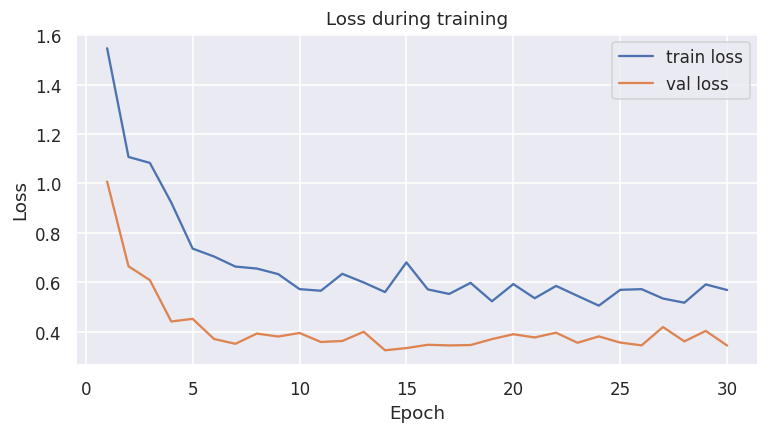

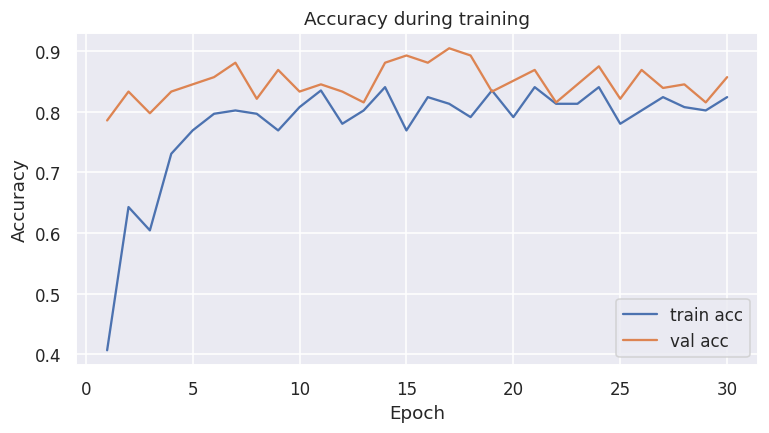

In [ ]:
plt.figure()
plt.plot(np.arange(1, NUM_EPOCH+1), train_loss_history, label="train loss")
plt.plot(np.arange(1, NUM_EPOCH+1), val_loss_history, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(1, NUM_EPOCH+1), train_accuracy_history, label="train acc")
plt.plot(np.arange(1, NUM_EPOCH+1), val_accuracy_history, label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy during training")
plt.legend()
plt.show()

In [ ]:
#torch.save(model.state_dict(), 'models/model_class')

# **Model performance**

In [ ]:
model.load_state_dict(torch.load('models/model_class'))

<All keys matched successfully>

In [ ]:
def display_stats_and_confusion_matrix(y_pred, y, names=CLASSES):

    cm = confusion_matrix(y,y_pred)
    cm = pd.DataFrame(cm , index = names , columns = names)
    cm.index.name = 'Label'
    cm.columns.name = 'Predicted'

    precision, recall, fscore, support = precision_recall_fscore_support(y_pred, y, average=None)
    print("#########################")
    for p,l in zip(precision, names):
        print("#### Precision for %s %.2f" % (l, p))
    print("#########################")        
    for r,l in zip(recall, names):
        print("#### Recall for %s %.2f" % (l, r))
    print("#########################")        
    for f,l in zip(fscore, names):
        print("#### F1Score for %s %.2f" % (l, f))
    print("#########################")

    group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
    # Percentage are normalized so as to interpret read values
    group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(6,6)

    plt.figure(figsize = (10,10))
    sns.heatmap(cm,
                annot=labels,
                cmap= "coolwarm",
                linecolor = 'black',
                linewidth = 1,
                fmt='')   

In [ ]:
y_pred, y_true = [], []
true_predicted_indexes, false_predicted_indexes = [], []

def predict_validation(dataset):
    
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        image = torch.tensor(np.array(image)).reshape(1, *image.shape)
        y_true.append(label)
    
        model.eval()
        image = image.to(device)
        
        with torch.set_grad_enabled(False):
            preds = model(image)
        pred_label = torch.nn.functional.softmax(preds, dim=1).argmax(dim=1)[0].data.cpu().numpy()
        y_pred.append(pred_label)
        if pred_label == label:
            true_predicted_indexes.append(idx)
        else:
            false_predicted_indexes.append(idx)

In [ ]:
def predict_label(dataset, idx):
    image, label = dataset[idx]
    image = torch.tensor(np.array(image)).reshape(1, *image.shape)

    model.eval()   
    image = image.to(device)
    
    with torch.set_grad_enabled(False):
        preds = model(image)
    pred_label = torch.nn.functional.softmax(preds, dim=1).argmax(dim=1)[0].data.cpu().numpy()
    
    return np.array(image), pred_label, label

In [ ]:
def visualize_validation(indexes, row=4, col=2):
    row, col = row, col
    plt.figure(figsize=(20,(row/col)*13))
    
    for x in range(row*col):
        plt.subplot(row,col,x+1)
        plt.xticks([]); plt.yticks([])
        
        idx = indexes[x]
        image, prediction, label = predict_label(valid_dataset, idx)
        image = denormalize(image.reshape(224,224, 3))
        plt.title(f'predicted: {CLASSES[prediction]},\n true: {CLASSES[label]}')
        plt.imshow(image)
    plt.show()

In [ ]:
predict_validation(valid_dataset)

#########################
#### Precision for c_kefir 1.00
#### Precision for staphylococcus_epidermidis 0.00
#### Precision for ent_cloacae 1.00
#### Precision for staphylococcus_aureus 1.00
#### Precision for klebsiella_pneumoniae 1.00
#### Precision for moraxella_catarrhalis 0.50
#########################
#### Recall for c_kefir 0.94
#### Recall for staphylococcus_epidermidis 0.00
#### Recall for ent_cloacae 1.00
#### Recall for staphylococcus_aureus 0.50
#### Recall for klebsiella_pneumoniae 1.00
#### Recall for moraxella_catarrhalis 0.62
#########################
#### F1Score for c_kefir 0.97
#### F1Score for staphylococcus_epidermidis 0.00
#### F1Score for ent_cloacae 1.00
#### F1Score for staphylococcus_aureus 0.67
#### F1Score for klebsiella_pneumoniae 1.00
#### F1Score for moraxella_catarrhalis 0.56
#########################


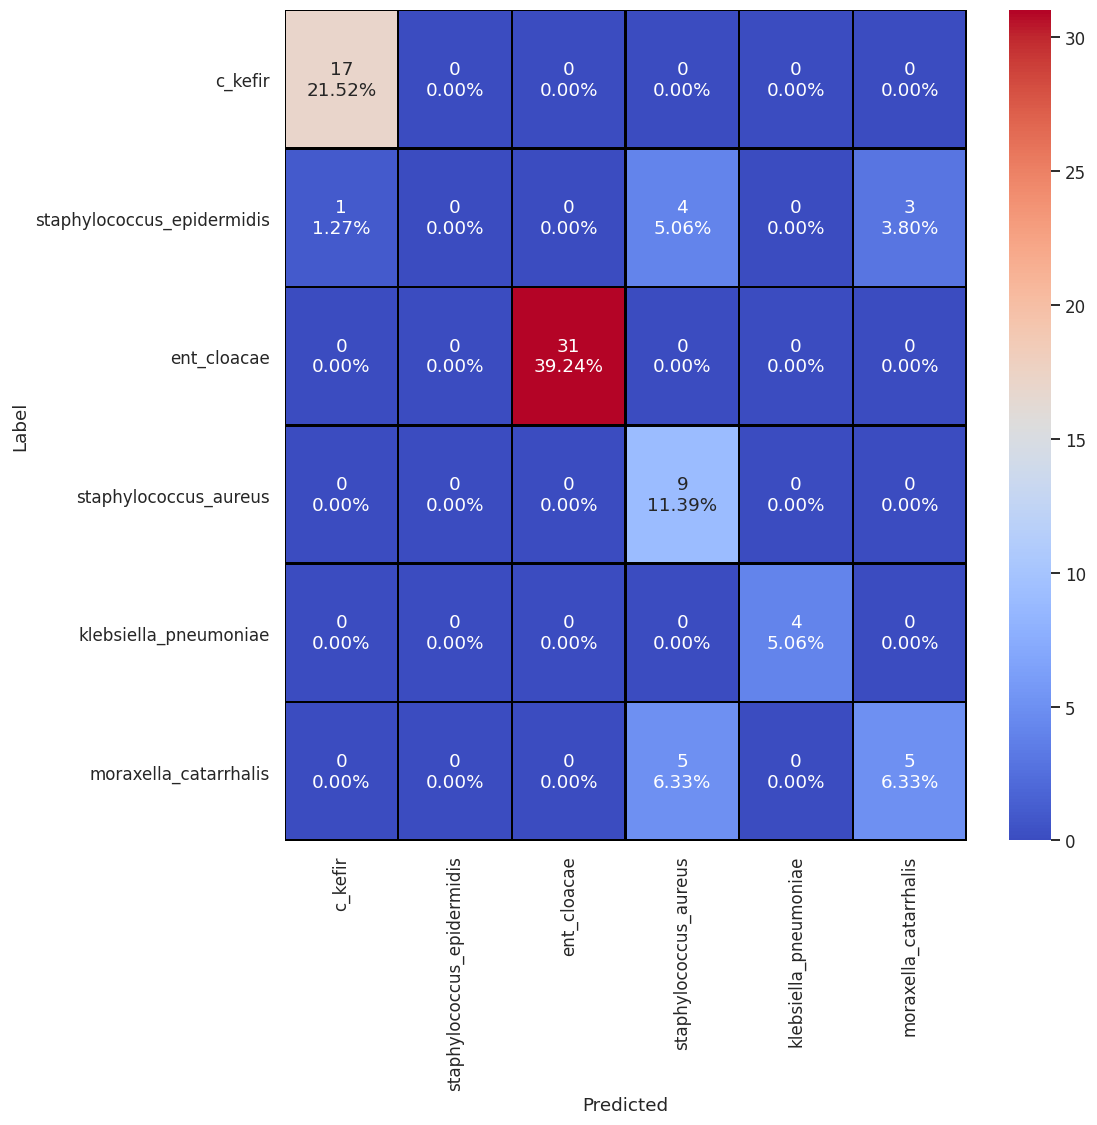

In [ ]:
display_stats_and_confusion_matrix(y_pred, y_true)

In [ ]:
len(true_predicted_indexes), len(false_predicted_indexes)

(66, 13)

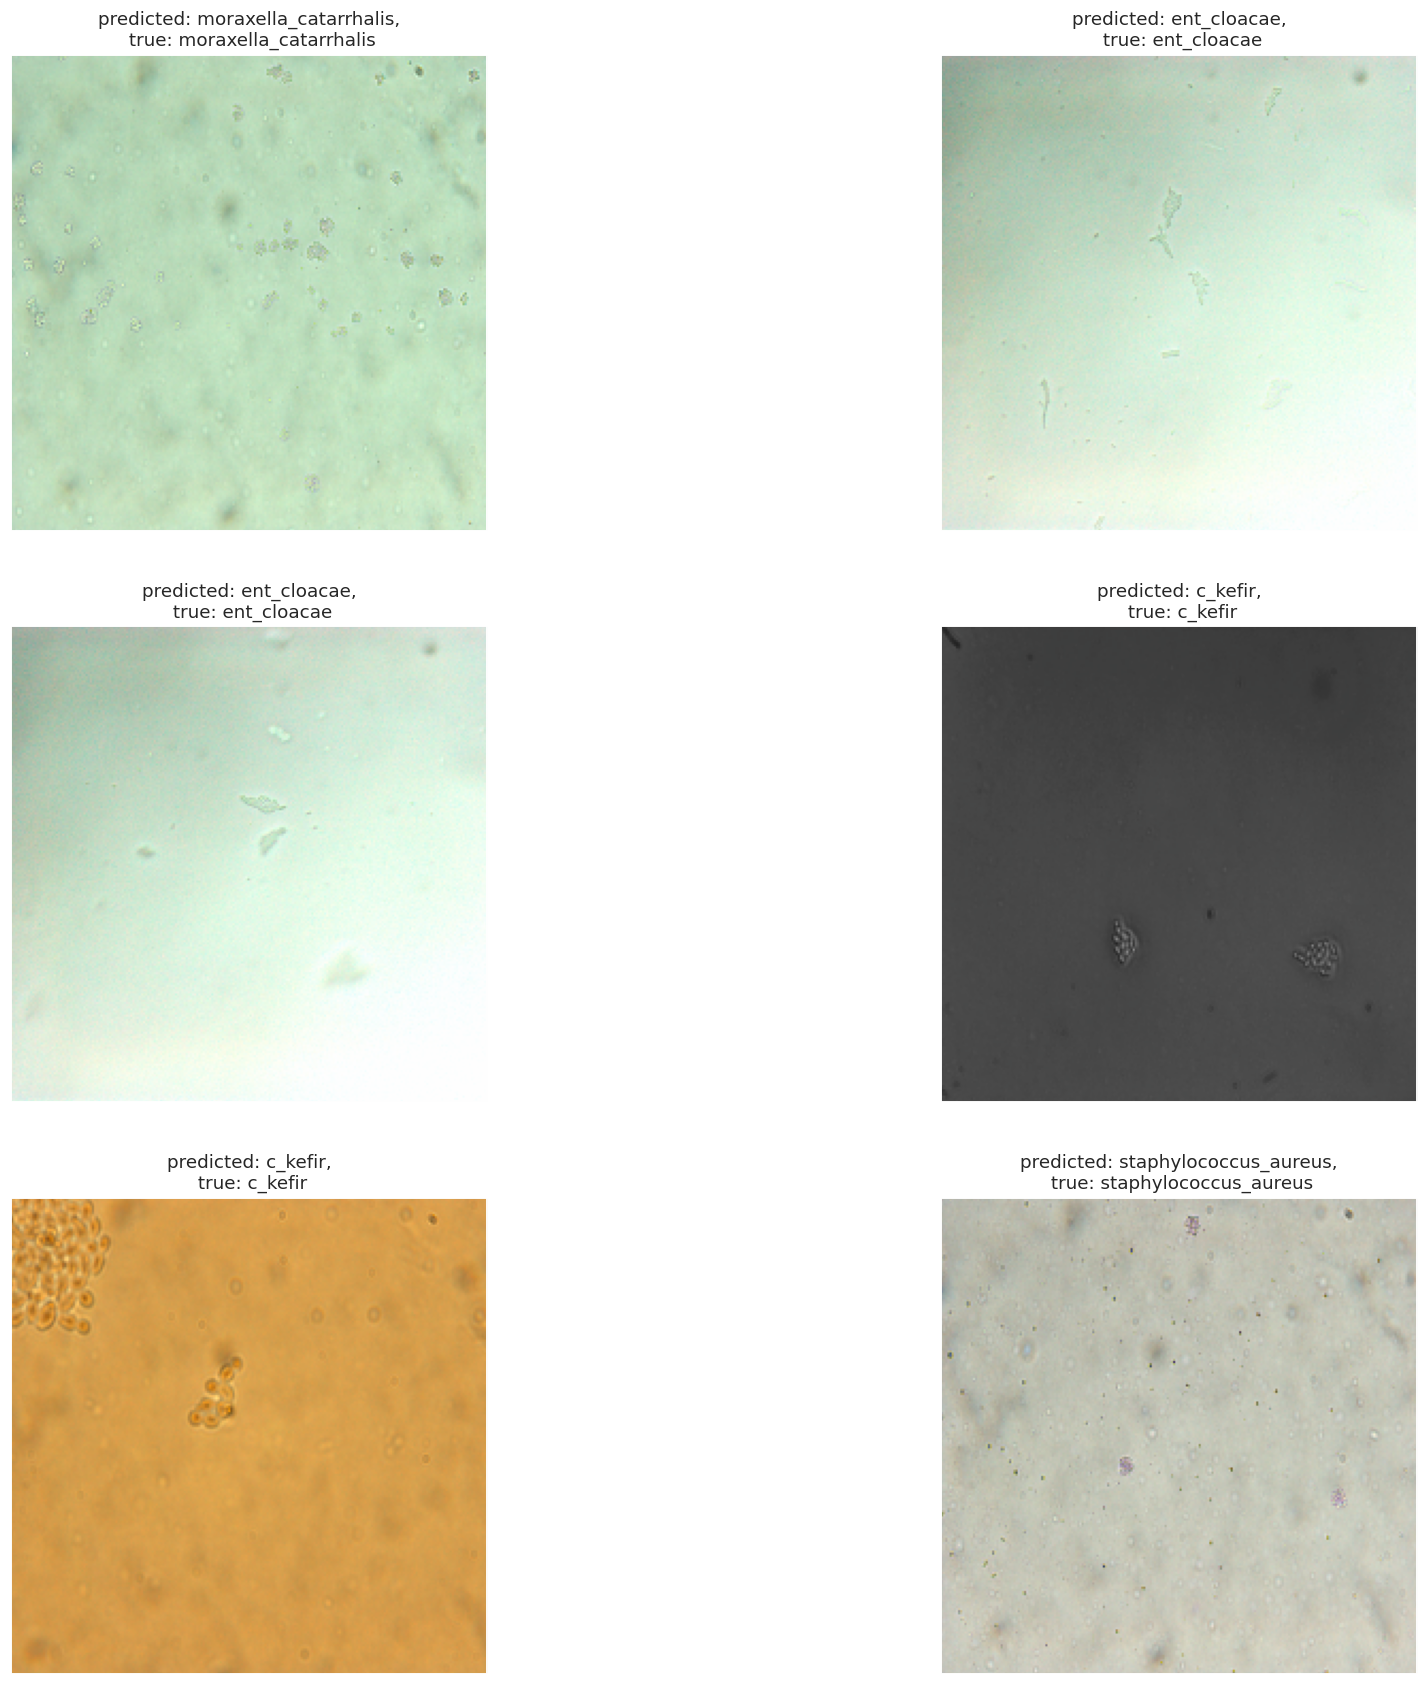

In [ ]:
row, col = 3, 2
indexes = np.random.choice(true_predicted_indexes, row*col, replace=False)
visualize_validation(indexes, row, col)

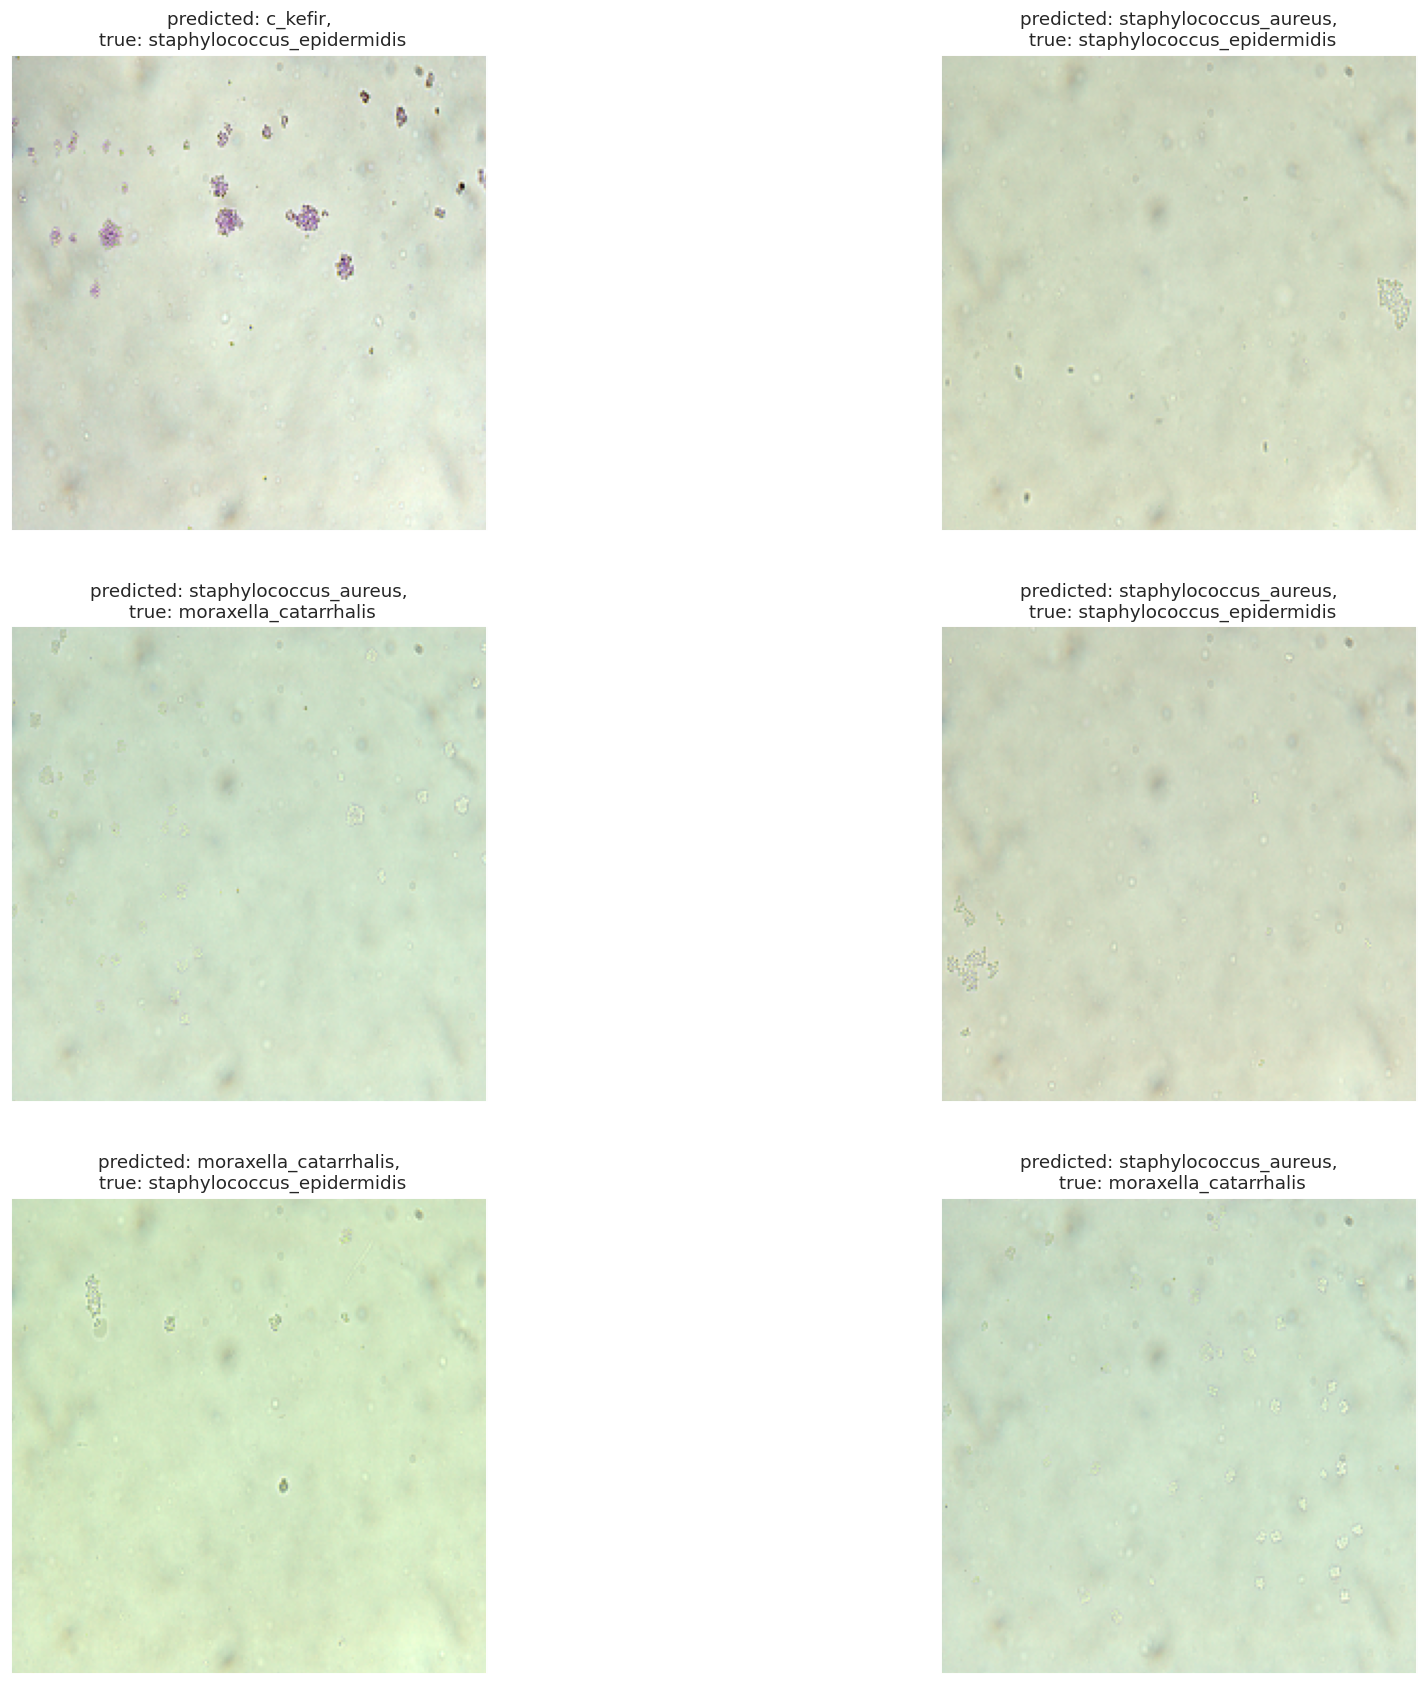

In [ ]:
row, col = 3, 2
indexes = np.random.choice(false_predicted_indexes, row*col, replace=False)
visualize_validation(indexes, row, col)

# **Test images classification**

In [ ]:
test_dataset = datasets.ClassificationTestDataset(
    TEST_DIR,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(),
    reshape=True
    )

In [ ]:
len(test_dataset)

107

In [ ]:
test_predictions = []

for index in range(len(test_dataset)):
    
    img = test_dataset[index]
    img = torch.tensor(np.array(img)).reshape(1, *img.shape)
    model.eval()   
    img = img.to(device)
    with torch.set_grad_enabled(False):
        preds = model(img)
    pred_label = torch.nn.functional.softmax(preds, dim=1).argmax(dim=1)[0].data.cpu().numpy()
    test_predictions.append(pred_label)

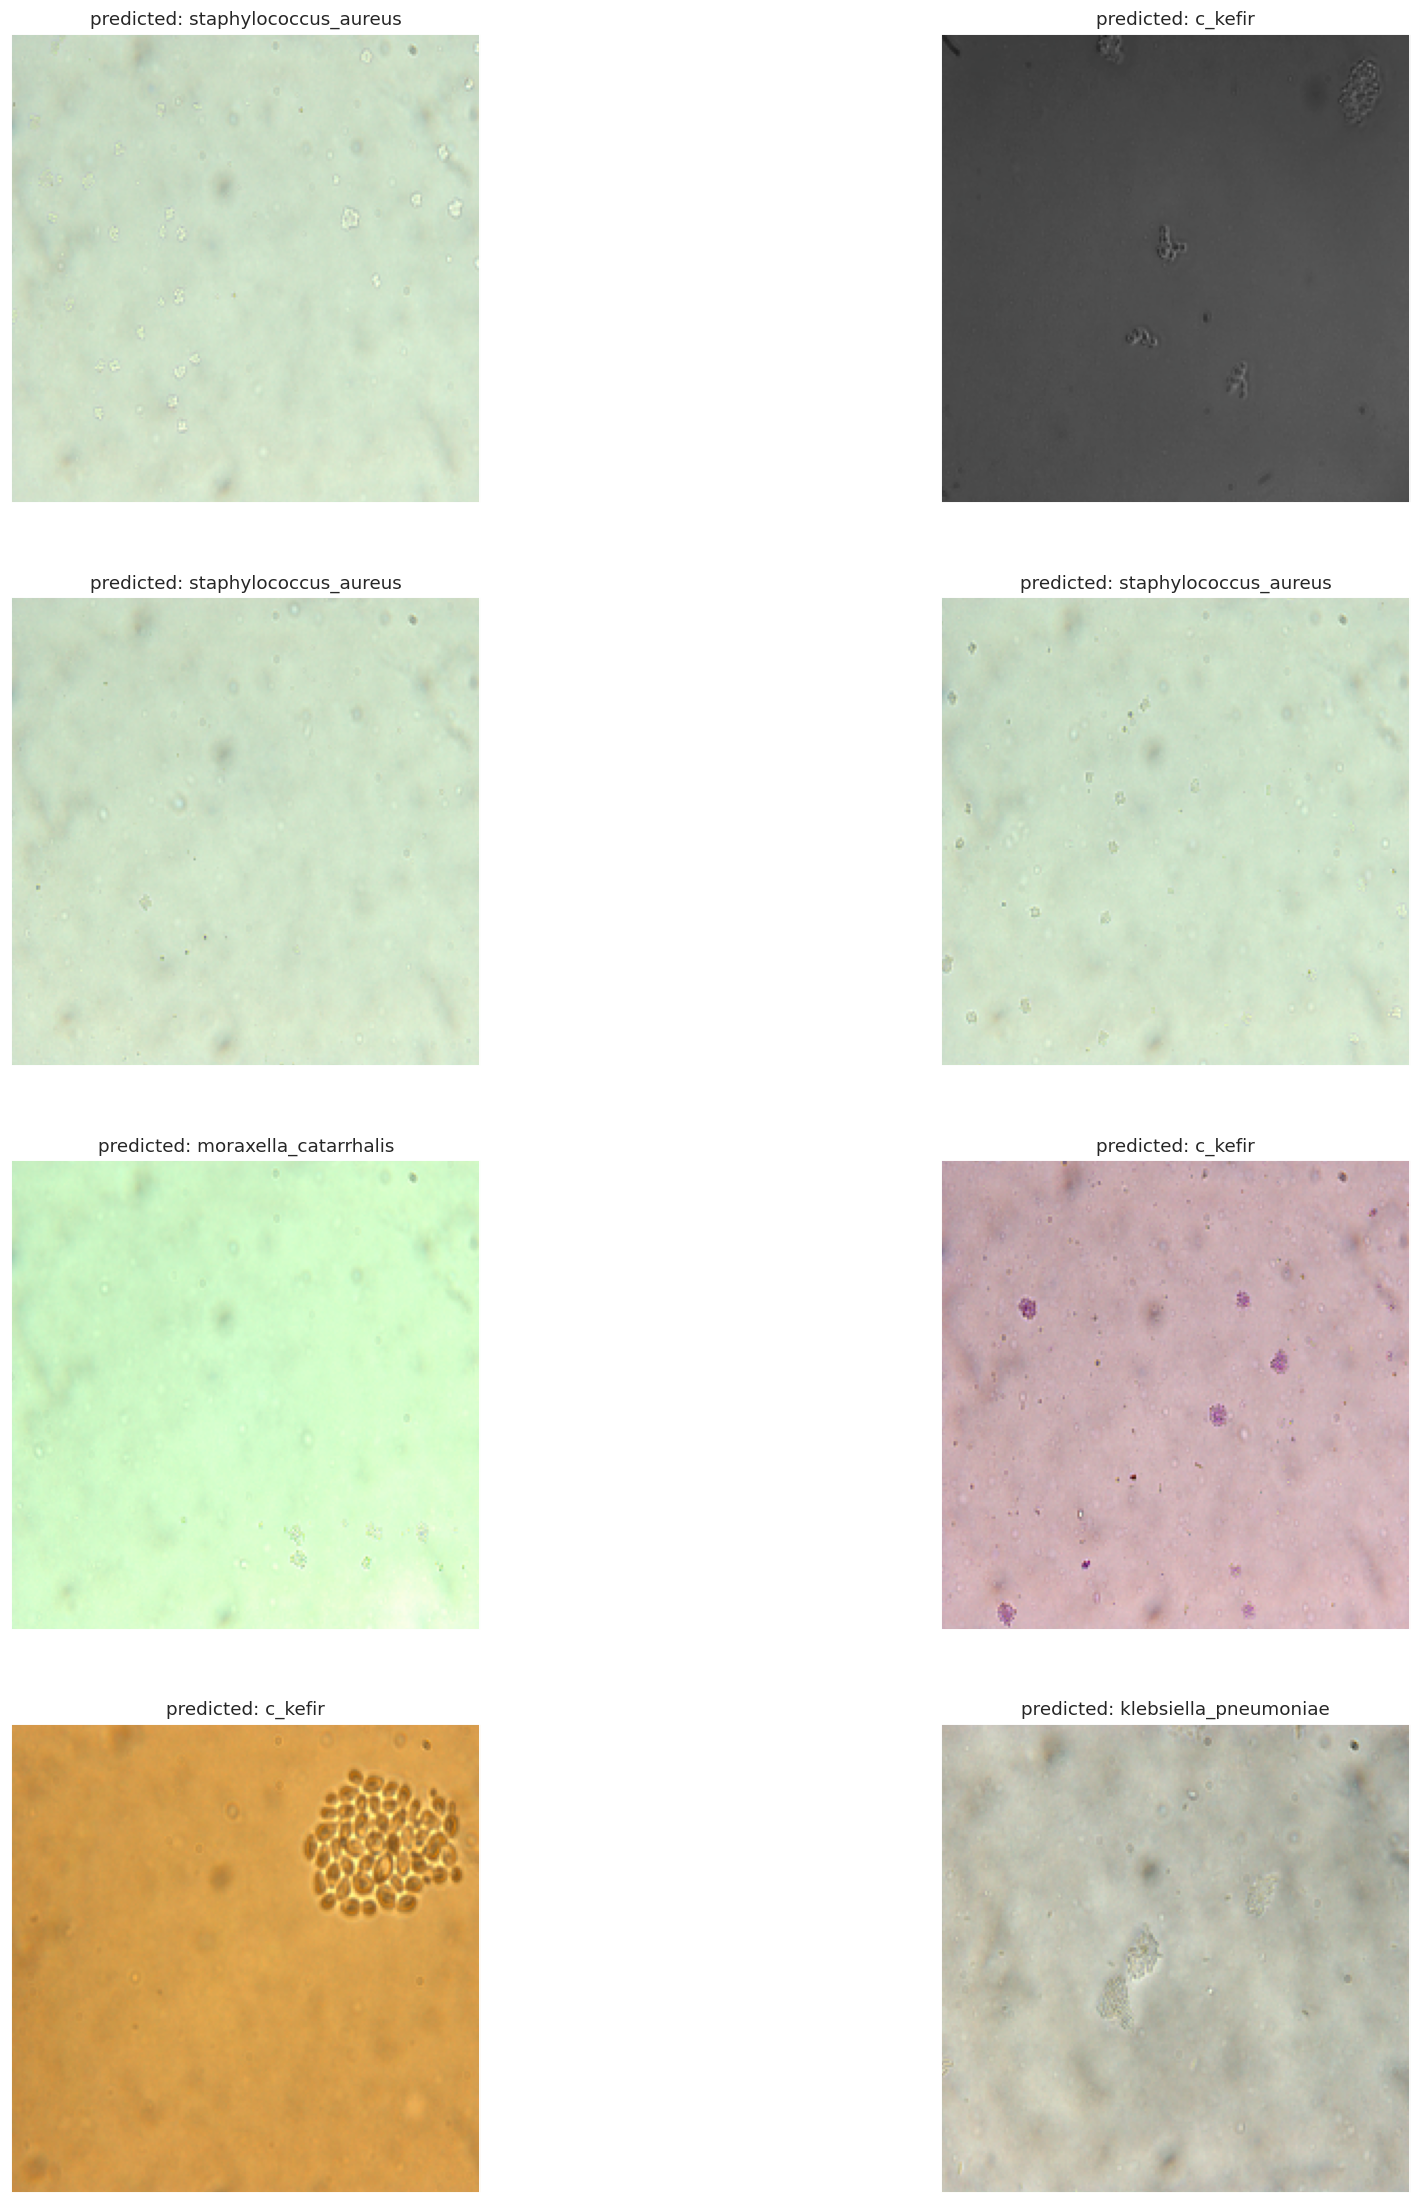

In [ ]:
row, col = 4, 2
plt.figure(figsize=(20,(row/col)*13))

indexes = np.random.choice(np.arange(len(test_dataset)), row*col, replace=False)

for x in range(row*col):
    plt.subplot(row,col,x+1)
    plt.xticks([]); plt.yticks([])

    idx = indexes[x]
    image = denormalize(test_dataset[idx].reshape(224,224,3))
    prediction = test_predictions[idx]
    plt.title(f"predicted: {CLASSES[prediction]}")
    plt.imshow(image)
plt.show()